In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()

In [2]:
foodie_df = pd.read_csv('Clean_FoodieX_data.csv')
foodie_df.head()

,Restaurant,Latitude,Longitude,Cuisines,Average_Cost,Minimum_Order,Rating,Votes,Reviews,Cook_Time_Mins,Numeric_Rating
0,ID_6321,39.262605,-85.837372,"Fast Food, Rolls, Burger, Salad, Wraps",20.0,50.0,3.5,12.0,4.0,30,3.5
1,ID_2882,39.775933,-85.740581,"Ice Cream, Desserts",10.0,50.0,3.5,11.0,4.0,30,3.5
2,ID_1595,39.253436,-85.123779,"Italian, Street Food, Fast Food",15.0,50.0,3.6,99.0,30.0,65,3.6
3,ID_5929,39.029841,-85.332050,"Mughlai, North Indian, Chinese",25.0,99.0,3.7,176.0,95.0,30,3.7
4,ID_6123,39.882284,-85.517407,"Cafe, Beverages",20.0,99.0,3.2,521.0,235.0,65,3.2


**Idea:**
* ``Weighted_Rating`` = ``Rating`` * (``Votes`` / ``Min_Votes_Threshold`` + ``Votes``)


* (``Votes`` / ``Min_Votes_Threshold`` + ``Votes``) acts as a reliablity ensurer. The more votes a record has, the closer the ``Weighted_Rating`` will be to the ``Rating``.
    * For example, if a record has a ``Rating`` of 5 but it only has 1 vote, the ``Weighted_Rating`` would be ``5 * 1/51 = 0.098`` (if the threshold is 50). On the other hand, if a restaurant has a ``Rating`` of 4 but has 1000 votes, the ``Weighted_Rating`` would be ``4 * 1000/1050 = 3.81``.


* Here, I don't include ``Reviews`` because it's very similar to ``Votes`` (they're strongly correlated as seen in the EDA)


* For records that don't have ``Rating`` and ``Votes``, take the mean of the records with the same ``Avg_cost`` and ``Cook_Time``. As we have seen, these are the two variables that are most correlated to ``Rating`` and ``Votes`` (``Reviews`` is not considered because a record having no ``Votes`` also has no information about ``Reviews``).

In [3]:
def fill_in(x, col):
    if pd.isna(x[col]):
        similar = foodie_df.loc[(foodie_df.Average_Cost==x.Average_Cost)&(foodie_df.Cook_Time_Mins==x.Cook_Time_Mins)][col]
        return similar.mean()
    return x[col]
        
foodie_df['Votes'] = foodie_df.apply(lambda x: fill_in(x, 'Votes'), axis=1)
foodie_df['Numeric_Rating'] = foodie_df.apply(lambda x: fill_in(x, 'Numeric_Rating'), axis=1)

In [4]:
# here, I take the median to be the Min_Votes_Threshold (about 67).
min_votes_thres = foodie_df.Votes.median()
foodie_df['Weighted_Rating'] = foodie_df.Numeric_Rating * (foodie_df.Votes/(foodie_df.Votes + min_votes_thres))

In [5]:
top10 = foodie_df.nlargest(10, columns=['Weighted_Rating']).reset_index()
top10[['Restaurant', 'Votes', 'Numeric_Rating', 'Weighted_Rating']]

,Restaurant,Votes,Numeric_Rating,Weighted_Rating
0,ID_1064,9054.0,4.7,4.665031
1,ID_2051,3975.0,4.7,4.621101
2,ID_1666,4903.0,4.6,4.537196
3,ID_6915,2858.0,4.6,4.493299
4,ID_7924,1112.0,4.7,4.429649
5,ID_7678,1507.0,4.6,4.401766
6,ID_7739,1502.0,4.6,4.401135
7,ID_2421,2831.0,4.5,4.394647
8,ID_7158,2805.0,4.5,4.393693
9,ID_1160,914.0,4.7,4.375131


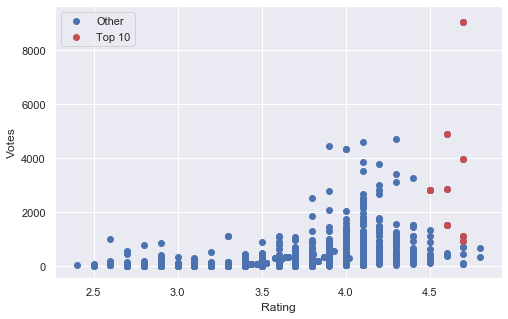

In [6]:
plt.figure(figsize=(8, 5))
plt.scatter(foodie_df.Numeric_Rating, foodie_df.Votes)
for idx in top10.index:
    plt.scatter(top10.iloc[idx].Numeric_Rating, top10.iloc[idx].Votes, color='r')
plt.ylabel('Votes')
plt.xlabel('Rating')
plt.legend(['Other', 'Top 10'])
plt.show()

**Comment:** We would want our algorithm to pick out restaurants with a high value of both ``Votes`` and ``Rating``. These should be the points in the top right corner of the graph above. As it can be seen, our algorithm has done a pretty good job.